In [6]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import datetime

In [3]:
# Load data
accel_raw = pd.read_csv("WISDM_at_v2.0/WISDM_at_v2.0_raw.txt", sep = ";|,", engine='python')  
accel_raw.columns = ["id", "tag", "time", "a_x", "a_y", "a_z", "to_drop"]
accel_raw = accel_raw.drop("to_drop",1)
accel_raw.head()






,id,tag,time,a_x,a_y,a_z
0,1679,Walking,1.370520e+12,-0.499688,-0.604451,-0.226020
1,1679,Walking,1.370520e+12,-2.178345,0.713491,0.372017
2,1679,Walking,1.370520e+12,-2.797763,1.354899,-0.277638
3,1679,Walking,1.370520e+12,-2.167961,-1.327716,-0.554971
4,1679,Walking,1.370520e+12,-1.734857,0.818559,-0.165544


In [4]:
# Low pass filter
plt.close()
# Code from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, sample_freq, order=5):
    nyq = 0.5 * sample_freq 
    normal_cutoff = cutoff / nyq #converts from frequency to cycles per half sample
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def get_sample_freq(time_stamps):
    nano = time_stamps[1] - time_stamps[0]
    seconds = nano/1e3
    return 1/seconds
    

(998, 6)


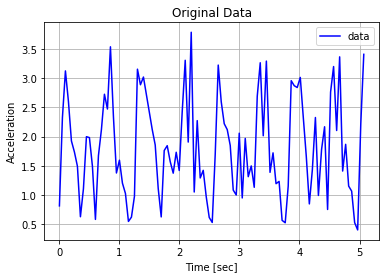

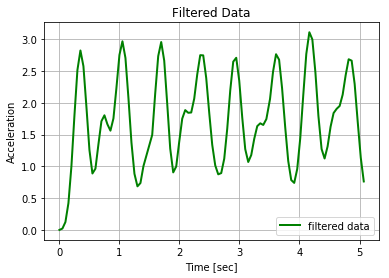

In [43]:
accel_one = accel_raw.loc[accel_raw['id'] == 1679]
print(accel_one.shape)

# Make vector with magnitude of accelerations for each data point
accel_mag = np.linalg.norm(accel_one[["a_x","a_y", "a_z"]].values, axis = 1)

# Filter requirements.
order = 6
fs = get_sample_freq(accel_one["time"].values)  # sample rate, Hz
cutoff = 3  # desired cutoff frequency of the filter, Hz

# Time stamps in seconds
t = accel_one["time"].values/1e3 - accel_one["time"][0]/1e3

# "Noisy" data.
data = accel_mag

# Filter the data, and plot both the original and filtered signals.
filtered_data = butter_lowpass_filter(data, cutoff, fs, order)

# Plot Filtered and Original Data
upper = 0
lower =  100
plt.plot(t[upper:lower], data[upper:lower], 'b-', label='data')
#plt.plot(t[upper:lower], filtered_data[upper:lower], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.title('Original Data')
plt.ylabel("Acceleration")
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.35)
plt.savefig("original_and_filtered.png")
plt.show()

# Plot Filtered Data
plt.figure()
plt.plot(t[upper:lower], filtered_data[upper:lower], 'g-', linewidth=2, label='filtered data')
plt.legend()
plt.grid()
plt.title('Filtered Data')
plt.xlabel('Time [sec]')
plt.ylabel("Acceleration")
plt.savefig("filtered.png")
plt.show()


In [13]:
# Finding i*

# Finding the correlation distance; smaller number means more similar
def corr_dist(u, v):
    centered_u = u - np.mean(u)
    centered_v = v - np.mean(v)
    return 1 - centered_u.T@centered_v/(np.linalg.norm(centered_u)*np.linalg.norm(centered_v))
    

# Global max of filtered data 
# Note: different from paper because min gives zero
i_tilde = np.argmax(filtered_data)
print(i_tilde)

# Max within 10 observations of i_tilde of unfiltered data
# Why do we do - 10 here???
i_star = np.argmax(accel_mag[i_tilde-10:i_tilde+10]) - 10 + i_tilde

# Finding template
# Acceleration within a half second on either side of i_star
template_size =2*np.floor(fs*0.5).astype(int)
template = accel_mag[i_star - template_size//2 : i_star + template_size//2]



175


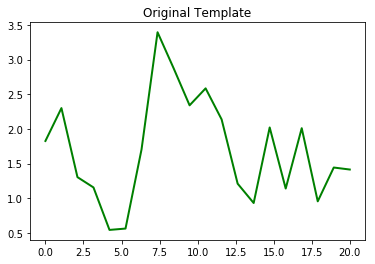

yup
yup
yup
yup
yup
yup
yup
yup
yup
yup
yup


/Users/georgiapope/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


yup
yup
yup
yup
yup


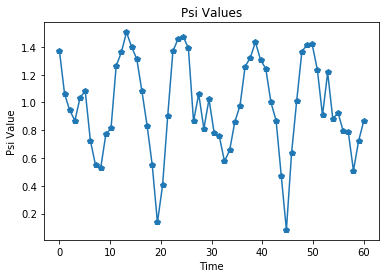

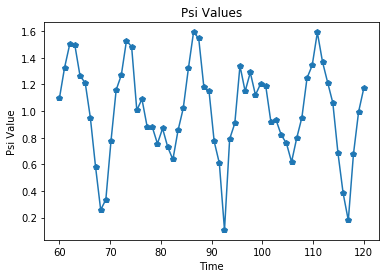

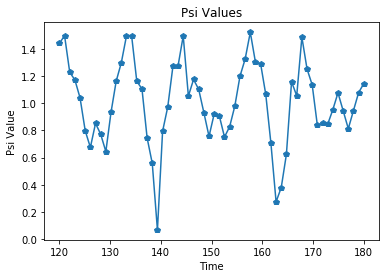

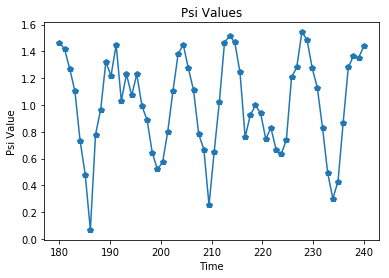

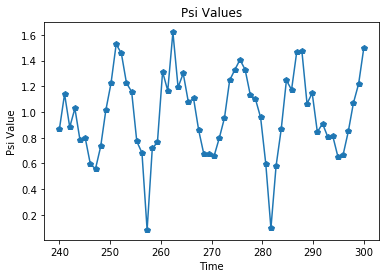

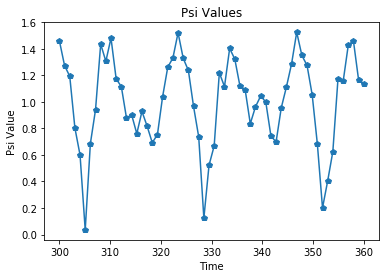

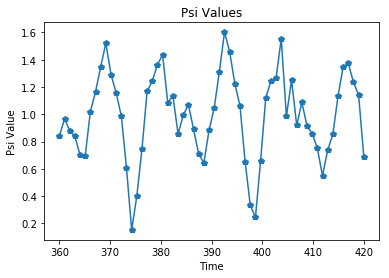

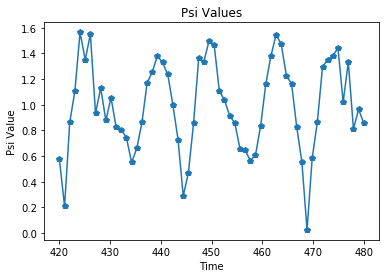

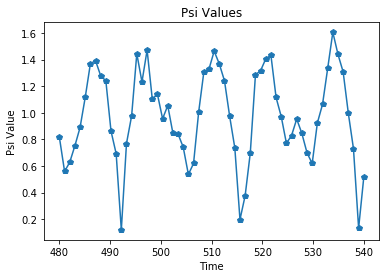

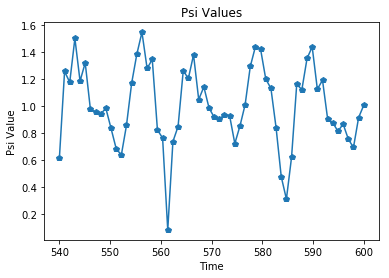

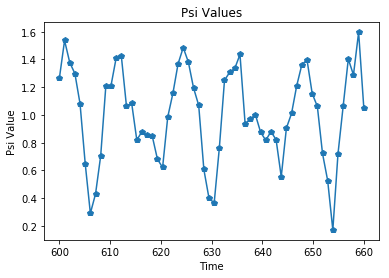

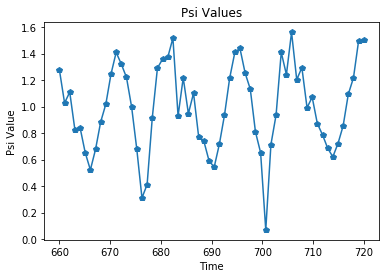

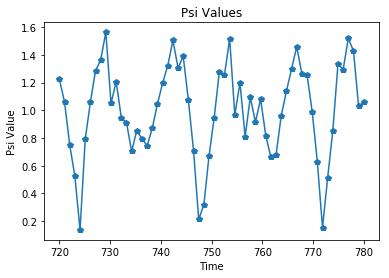

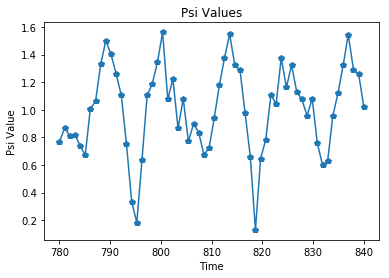

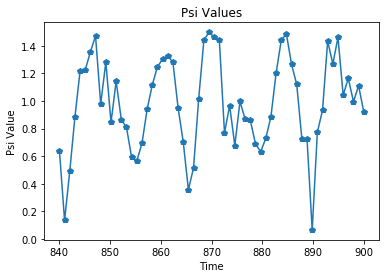

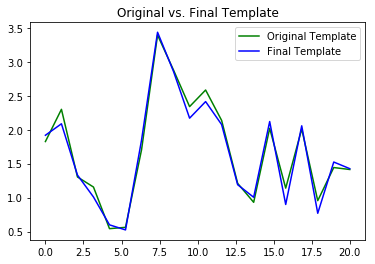

In [41]:
# Find psi(i)

template_updates = 30
psi_threshold = .4
window_size = 3*template_size
i_min = 0
i_max = window_size
alpha = 0.85 #this probably needs to change
psi_min_vals = []

original_template = template

j = 0

plt.close()

# Plot original template
t = np.linspace(0, template_size, template_size)
plt.plot(t, template, 'g-', linewidth=2, label='Template')
plt.title("Original Template")
plt.show()

while j < template_updates:
    
    # Make sure we don't index out of range
    if i_max >= accel_mag.shape[0] - template_size:
        break
    
    # Update psi values for current template
    psi_vals = np.zeros(window_size)
    for i in range(i_min, i_max):
        psi_vals[i - i_min] = corr_dist(template, accel_mag[i:i+template_size])
   
      # Plot psi_vals
    plt.figure()
    psi_t = np.linspace(i_min, i_max, i_max-i_min)
    plt.figure()
    plt.plot(psi_t, psi_vals, 'p-')
    plt.title('Psi Values')
    plt.xlabel('Time')
    plt.ylabel('Psi Value')
    
    # Find first psi value below psi_threshold between i_min and i_max
    psi_min = np.argmin(psi_vals)

    
    t_prime = accel_mag[i_min+psi_min:i_min + psi_min + template_size]
    if psi_vals[psi_min] < psi_threshold:
        print('yup')
        template = template*alpha + (1 - alpha)*t_prime
        j += 1
        psi_min_vals.append(psi_vals[psi_min])
        # Plot progress of template
#         plt.plot(t, template, 'b-', linewidth=2, label='Template')
#         plt.plot(t, t_prime, 'r-', linewidth=2, label='Data')
#         plt.legend()
#         plt.title("Template Progress")
#         plt.show()
      
    i_min += window_size
    i_max += window_size
    
    
#print(psi_min_vals)
# lower = 250
# upper = 750
# t = np.linspace(1, len(psi_min_vals), len(psi_min_vals)-1)
# plt.close()
# plt.plot(t, psi_min_vals[1:], 'g-', linewidth=2, label='Psi Values')
# plt.legend()
# plt.grid()
# plt.show()

plt.close()
plt.plot(t, original_template, 'g-', label = "Original Template")
plt.plot(t, template, 'b-', label = "Final Template")
plt.legend()
plt.title("Original vs. Final Template")
plt.show()

